**Importing Libraries**

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from textblob import TextBlob
from wordcloud import WordCloud

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Set style for plots
sns.set_style('whitegrid')
plt.style.use('fivethirtyeight')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


**Data Loading and Exploration**

In [13]:
# Load the dataset
df = pd.read_csv('fifa_world_cup_tweets.csv')

# Display basic info
print(f"Dataset shape: {df.shape}")
print("\nFirst few rows:")
display(df.head())

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

# Check sentiment distribution
print("\nSentiment distribution:")
print(df['Sentiment'].value_counts())

Dataset shape: (22524, 6)

First few rows:


,Unnamed: 0,Date Created,Number of Likes,Source of Tweet,Tweet,Sentiment
0,0,2022-11-20 23:59:21+00:00,4,Twitter Web App,What are we drinking today @TucanTribe \n@MadB...,neutral
1,1,2022-11-20 23:59:01+00:00,3,Twitter for iPhone,Amazing @CanadaSoccerEN #WorldCup2022 launch ...,positive
2,2,2022-11-20 23:58:41+00:00,1,Twitter for iPhone,Worth reading while watching #WorldCup2022 htt...,positive
3,3,2022-11-20 23:58:33+00:00,1,Twitter Web App,Golden Maknae shinning bright\n\nhttps://t.co/...,positive
4,4,2022-11-20 23:58:28+00:00,0,Twitter for Android,"If the BBC cares so much about human rights, h...",negative



Missing values:
Unnamed: 0         0
Date Created       0
Number of Likes    0
Source of Tweet    0
Tweet              0
Sentiment          0
dtype: int64

Sentiment distribution:
Sentiment
positive    8489
neutral     8251
negative    5784
Name: count, dtype: int64


**Text Preprocessing**

In [14]:
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import pandas as pd # Ensure pandas is imported if not already in the cell

# Download required NLTK data, including punkt_tab
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
# Download the missing punkt_tab resource
nltk.download('punkt_tab')


# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    # Check if text is None or not a string before processing
    if text is None or not isinstance(text, str):
        return "" # Return an empty string or handle appropriately

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove user mentions
    text = re.sub(r'@\w+', '', text)
    # Remove hashtags
    text = re.sub(r'#\w+', '', text)
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stopwords.words('english')]
    # Join tokens back to string
    return ' '.join(tokens)

# Apply cleaning function
# Ensure 'Tweet' column exists and handle potential missing values in the column
if 'Tweet' in df.columns:
    df['cleaned_text'] = df['Tweet'].apply(clean_text)
else:
    print("Error: 'Tweet' column not found in the DataFrame.")
    # You might want to stop execution or handle this case differently
    # raise ValueError("Tweet column not found")


# Display cleaned text
print("\nOriginal vs Cleaned Text:")
display(df[['Tweet', 'cleaned_text']].head())

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!



Original vs Cleaned Text:


,Tweet,cleaned_text
0,What are we drinking today @TucanTribe \n@MadB...,drinking today
1,Amazing @CanadaSoccerEN #WorldCup2022 launch ...,amazing launch video show much face canada men...
2,Worth reading while watching #WorldCup2022 htt...,worth reading watching
3,Golden Maknae shinning bright\n\nhttps://t.co/...,golden maknae shinning bright
4,"If the BBC cares so much about human rights, h...",bbc care much human right homosexual right wom...


**Approach 1: TextBlob Sentiment Analysis**

In [15]:
# Function to get sentiment polarity
def get_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

df['sentiment_polarity'] = df['cleaned_text'].apply(get_sentiment)

# Categorize sentiment based on polarity
def categorize_sentiment(polarity):
    if polarity > 0:
        return 'positive'
    elif polarity < 0:
        return 'negative'
    else:
        return 'neutral'

df['textblob_sentiment'] = df['sentiment_polarity'].apply(categorize_sentiment)

# Compare with original sentiment labels
print("\nTextBlob Sentiment vs Original Labels:")
print(pd.crosstab(df['Sentiment'], df['textblob_sentiment']))


TextBlob Sentiment vs Original Labels:
textblob_sentiment  negative  neutral  positive
Sentiment                                      
negative                2110     2000      1674
neutral                  958     4504      2789
positive                 536     2938      5015


**Approach 2: Machine Learning Model**

In [16]:
# Prepare data for ML model
# We'll use the original labels for supervised learning
X = df['cleaned_text']
y = df['Sentiment']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorize text
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Train Logistic Regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf, y_train)

# Predictions
y_pred = model.predict(X_test_tfidf)

# Evaluate model
print("\nModel Evaluation:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print(f"\nAccuracy: {accuracy_score(y_test, y_pred):.2f}")


Model Evaluation:
              precision    recall  f1-score   support

    negative       0.75      0.64      0.69      1149
     neutral       0.64      0.71      0.67      1648
    positive       0.75      0.75      0.75      1708

    accuracy                           0.71      4505
   macro avg       0.71      0.70      0.70      4505
weighted avg       0.71      0.71      0.71      4505


Confusion Matrix:
[[ 731  313  105]
 [ 169 1169  310]
 [  76  355 1277]]

Accuracy: 0.71


**Visualizations and Insights**

<ipython-input-17-898535740d6b>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Sentiment', data=df, palette='viridis')


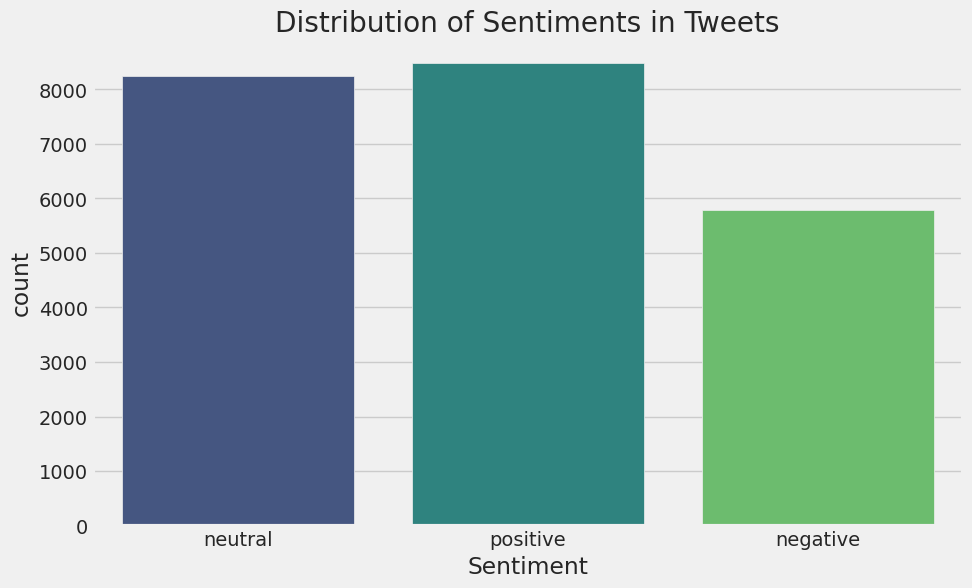

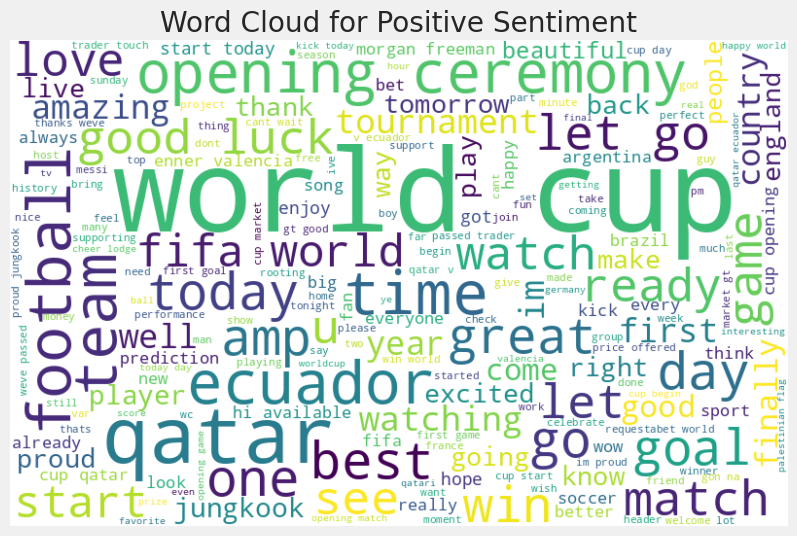

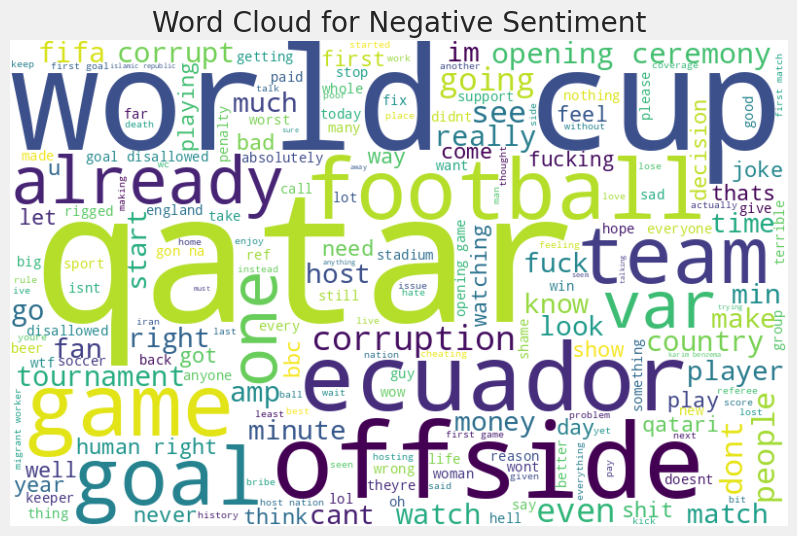

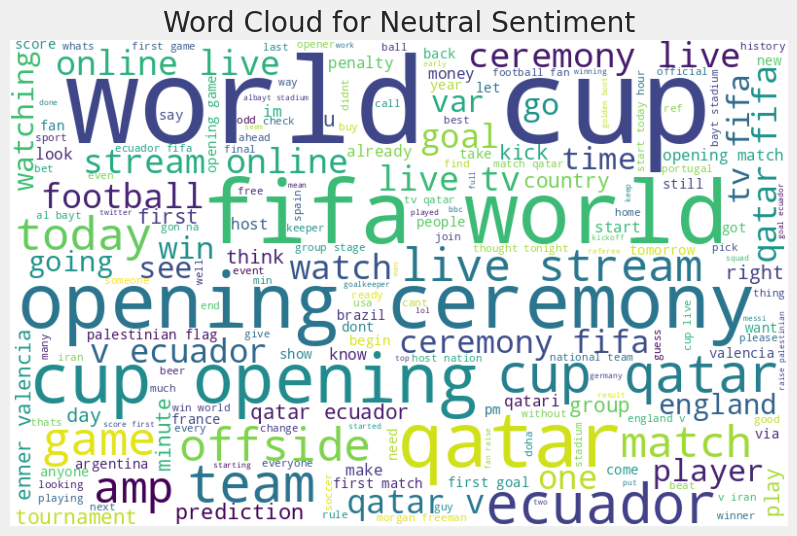


Top Terms by Sentiment:

POSITIVE Sentiment:


,term,rank
97,world,688.582410
17,cup,648.144935
72,qatar,420.397463
56,let,361.489261
38,go,315.757015
66,opening,269.899784
83,team,260.218900
20,ecuador,254.469036
87,today,253.375152
86,time,246.723851



NEGATIVE Sentiment:


,term,rank
66,qatar,468.706930
95,world,341.704537
57,offside,316.201369
11,cup,302.002002
32,goal,243.236579
0,already,196.678116
87,var,189.226467
9,corruption,179.725496
28,game,173.405442
17,ecuador,171.115627



NEUTRAL Sentiment:


,term,rank
66,qatar,694.600610
97,world,647.798334
10,cup,625.582488
13,ecuador,357.919395
54,offside,330.552270
57,opening,324.404159
17,fifa,288.934313
28,goal,280.500394
8,ceremony,239.900681
48,match,231.876726


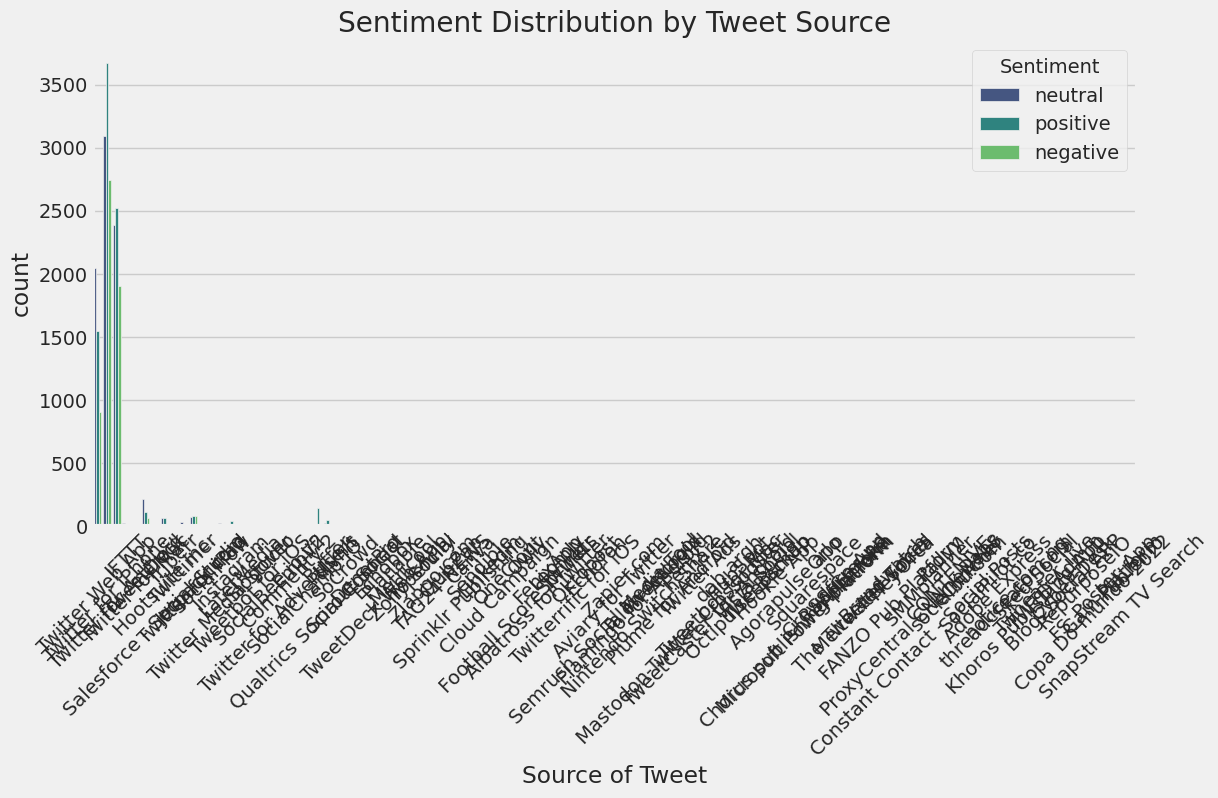

In [17]:
# Sentiment distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='Sentiment', data=df, palette='viridis')
plt.title('Distribution of Sentiments in Tweets')
plt.show()

# Word clouds for each sentiment
def generate_wordcloud(sentiment):
    text = ' '.join(df[df['Sentiment'] == sentiment]['cleaned_text'])
    wordcloud = WordCloud(width=800, height=500, background_color='white').generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {sentiment.capitalize()} Sentiment')
    plt.axis('off')
    plt.show()

for sentiment in ['positive', 'negative', 'neutral']:
    generate_wordcloud(sentiment)

# Top terms by sentiment
def top_terms_by_sentiment(sentiment, n=10):
    sentiment_df = df[df['Sentiment'] == sentiment]
    vectorizer = TfidfVectorizer(max_features=100)
    X = vectorizer.fit_transform(sentiment_df['cleaned_text'])
    terms = vectorizer.get_feature_names_out()
    sums = X.sum(axis=0)
    data = []
    for col, term in enumerate(terms):
        data.append((term, sums[0,col]))
    ranking = pd.DataFrame(data, columns=['term', 'rank'])
    return ranking.sort_values('rank', ascending=False).head(n)

print("\nTop Terms by Sentiment:")
for sentiment in ['positive', 'negative', 'neutral']:
    print(f"\n{sentiment.upper()} Sentiment:")
    display(top_terms_by_sentiment(sentiment))

# Sentiment by source
plt.figure(figsize=(12, 6))
sns.countplot(x='Source of Tweet', hue='Sentiment', data=df, palette='viridis')
plt.title('Sentiment Distribution by Tweet Source')
plt.xticks(rotation=45)
plt.show()

In [18]:
# Save the processed data with sentiment analysis
df.to_csv('processed_tweets_with_sentiment.csv', index=False)
print("Analysis complete. Processed data saved.")

Analysis complete. Processed data saved.
